In [1]:
import pandas as pd
import random
import numpy as np
import pprint

In [2]:
# Load dataset features
df = pd.read_csv('*\ImageClassificationMethods\feature\feature.csv')

In [3]:
def train_test_split(df, test_size):

    if isinstance(test_size, float):
        test_size = round(test_size * len(df)) #eg: test_size = 0.2 -> 20% x df

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [4]:
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    #unique_classes = 0 and 1 (kamm, burst) -> length = 2
    #if length only 1 -> only 1 class -> data pure -> True
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [5]:
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

In [6]:
def get_potential_splits(data):

    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):        # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)

    return potential_splits

In [7]:
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]

    return data_below, data_above

In [8]:
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [9]:
def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))

    return overall_entropy

In [10]:
def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


In [11]:
sub_tree = {"question": ["yes_answer",
                         "no_answer"]}

In [12]:
def decision_tree_algorithm(df, counter=0, max_depth = 10):

    # data preparations
    if counter == 0:          #at first, data still data frame and it needs to be converted to the numpy 2Darray (without header)
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df


    # base cases (stop condition so recursive not go infinitiv)
    if (check_purity(data)) or (counter == max_depth):
        classification = classify_data(data)
        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # instantiate sub-tree
        feature_name= COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, max_depth)

        if yes_answer == no_answer:
          sub_tree = yes_answer
        else:
          sub_tree[question].append(yes_answer)
          sub_tree[question].append(no_answer)

        return sub_tree


In [13]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [14]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df.classification == df.labels

    accuracy = df["classification_correct"].mean()

    return accuracy

In [15]:
random.seed(0)
train_df, test_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(train_df)
#tree = decision_tree_algorithm(train_df, max_depth=10)

pprint.pprint(tree, width=50)

#test_df

{'hull_rectangle_ratio <= 0.8077957415000001': [{'contour_length_area_ratio <= 0.037084545499999996': [{'contour_hull_length_ratio <= 1.1707387255000001': [1.0,
                                                                                                                                                            {'contour_hull_length_ratio <= 1.2103389574999999': [0.0,
                                                                                                                                                                                                                 1.0]}]},
                                                                                                       {'contour_length_hull_area_ratio <= 0.07590293849999999': [{'hull_area <= 27251.75': [{'contour_hull_length_ratio <= 1.0966656425': [{'harris_corners <= 234.0': [{'contour_rect_length_ratio <= 0.9333884605': [0.0,
                                                                                          

In [16]:
accuracy = calculate_accuracy(test_df, tree)
print(accuracy)
accuracy_per = accuracy *100
print("Accuracy: ", accuracy_per , "%")

0.74375
Accuracy:  74.375 %


### Decision Tree with sklearn 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import sklearn
import pandas as pd

dataset = pd.read_csv('data.csv')

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
print('X: ', X.shape, 'y: ',y.shape)

X:  (799, 17) y:  (799,)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

print('X_train: ', X_train.shape, 'y_train: ',y_train.shape)
print('X_test: ', X_test.shape, 'y_test:', y_test.shape)

X_train:  (639, 17) y_train:  (639,)
X_test:  (160, 17) y_test: (160,)


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

bktree_clf = DecisionTreeClassifier()

bktree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_df.labels, test_df.classification))


[[58 19]
 [22 61]]


[Text(116.06442018072288, 209.6742857142857, 'X[16] <= 0.84\ngini = 0.5\nsamples = 639\nvalue = [319, 320]'),
 Text(36.8078313253012, 194.14285714285714, 'X[9] <= 0.037\ngini = 0.356\nsamples = 229\nvalue = [176, 53]'),
 Text(12.101204819277108, 178.61142857142858, 'X[8] <= 1.596\ngini = 0.308\nsamples = 21\nvalue = [4, 17]'),
 Text(8.067469879518072, 163.07999999999998, 'X[15] <= 0.792\ngini = 0.188\nsamples = 19\nvalue = [2, 17]'),
 Text(4.033734939759036, 147.54857142857142, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(12.101204819277108, 147.54857142857142, 'X[6] <= 34.0\ngini = 0.105\nsamples = 18\nvalue = [1, 17]'),
 Text(8.067469879518072, 132.01714285714286, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(16.134939759036143, 132.01714285714286, 'gini = 0.0\nsamples = 17\nvalue = [0, 17]'),
 Text(16.134939759036143, 163.07999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(61.514457831325295, 178.61142857142858, 'X[11] <= 0.074\ngini = 0.286\nsamples = 208\nva

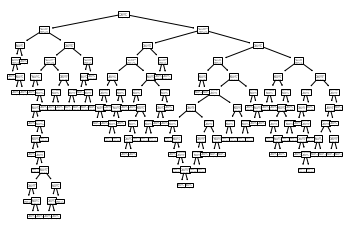

In [21]:
tree.plot_tree(bktree_clf)

In [22]:
print('Accuracy Decision Tree: ', bktree_clf.score(X_test,y_test))

Accuracy Decision Tree:  0.8125
